In [ ]:
import scanpy as sc
import pandas as pd

import os
import pickle
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection
import numpy as np
import matplotlib.pyplot as plt

In [11]:
np.random.seed(3)

In [47]:
adata_tu = sc.read_h5ad("/home/icb/raphael.kfuri-rubens/git/mempel_xenium/resegmentation_adatas_merged/merged_TU.h5ad")
adata_tu

AnnData object with n_obs × n_vars = 3487396 × 335
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'slide_id'
    uns: 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [48]:
adata_tu.obs["slide_id"].value_counts(dropna=False)

slide_id
resegment_output-XETG00323__0052425__TU_3__20250221__191919          692582
resegment_output-XETG00323__0052328__TU_aPDL1_2__20250221__191919    638882
resegment_output-XETG00323__0052425__TU_2__20250221__191919          622199
resegment_output-XETG00323__0052425__TU_1__20250221__191919          582731
resegment_output-XETG00323__0052328__TU_aPDL1_1__20250221__191919    556239
resegment_output-XETG00323__0052425__TU_aPDL1_3__20250221__191919    394763
Name: count, dtype: int64

In [49]:
mapping = {
    "resegment_output-XETG00323__0052425__TU_3__20250221__191919": "TU_3",
    "resegment_output-XETG00323__0052328__TU_aPDL1_2__20250221__191919": "TU_aPDL1_2",
    "resegment_output-XETG00323__0052425__TU_2__20250221__191919": "TU_2",
    "resegment_output-XETG00323__0052425__TU_1__20250221__191919": "TU_1",
    "resegment_output-XETG00323__0052328__TU_aPDL1_1__20250221__191919": "TU_aPDL1_1",
    "resegment_output-XETG00323__0052425__TU_aPDL1_3__20250221__191919": "TU_aPDL1_3"
}
adata_tu.obs["slide_id"] = adata_tu.obs["slide_id"].replace(mapping)
adata_tu.obs["slide_id"].value_counts(dropna=False)

/tmp/ipykernel_1640154/1574794051.py:9: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata_tu.obs["slide_id"] = adata_tu.obs["slide_id"].replace(mapping)


slide_id
TU_3          692582
TU_aPDL1_2    638882
TU_2          622199
TU_1          582731
TU_aPDL1_1    556239
TU_aPDL1_3    394763
Name: count, dtype: int64

In [50]:
adata_tu.obsm["unintegrated"] = adata_tu.obsm["X_pca"]

In [51]:
emb_dir = "/home/icb/raphael.kfuri-rubens/git/mempel_xenium/resegmentation_integration_embs"
tu_files = [f for f in os.listdir(emb_dir) if "TU" in f]

for file in tu_files:
    filepath = os.path.join(emb_dir, file)
    with open(filepath, "rb") as f:
        emb = pickle.load(f)
    if "drvi" in file:
        adata_tu.obsm["drvi"] = emb
    if "harmony" in file:
        adata_tu.obsm["harmony"] = emb
    if "scvi" in file:
        adata_tu.obsm["scvi"] = emb

adata_tu

AnnData object with n_obs × n_vars = 3487396 × 335
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'slide_id'
    uns: 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'unintegrated', 'drvi', 'harmony', 'scvi'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [ ]:
obs = adata_tu.obs

groups = obs.groupby("slide_id").groups  

keep_indices = []

for slide, idx in groups.items():
    idx = np.array(list(idx))
    n = len(idx)
    n_sub = max(1, int(n * 0.05))
    chosen = np.random.choice(idx, size=n_sub, replace=False)
    keep_indices.extend(chosen)

adata_tu_sub = adata_tu[keep_indices].copy()

/tmp/ipykernel_1640154/4064804179.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = obs.groupby("slide_id").groups


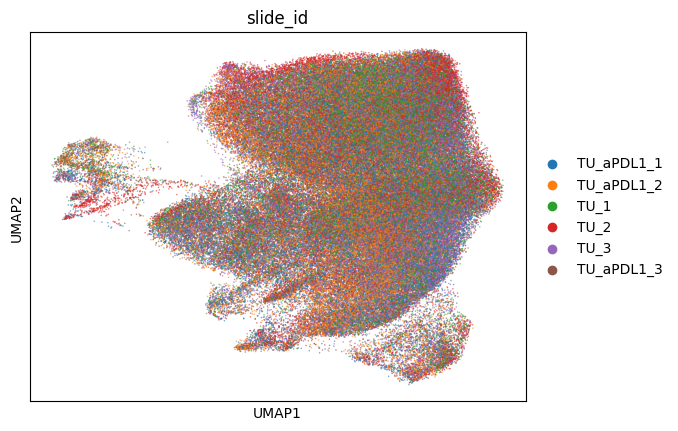

In [53]:
idx = np.random.permutation(adata_tu_sub.n_obs)
adata_shuffled = adata_tu_sub[idx, :].copy()
sc.pl.umap(adata_shuffled, color="slide_id", size=5, alpha=0.6)

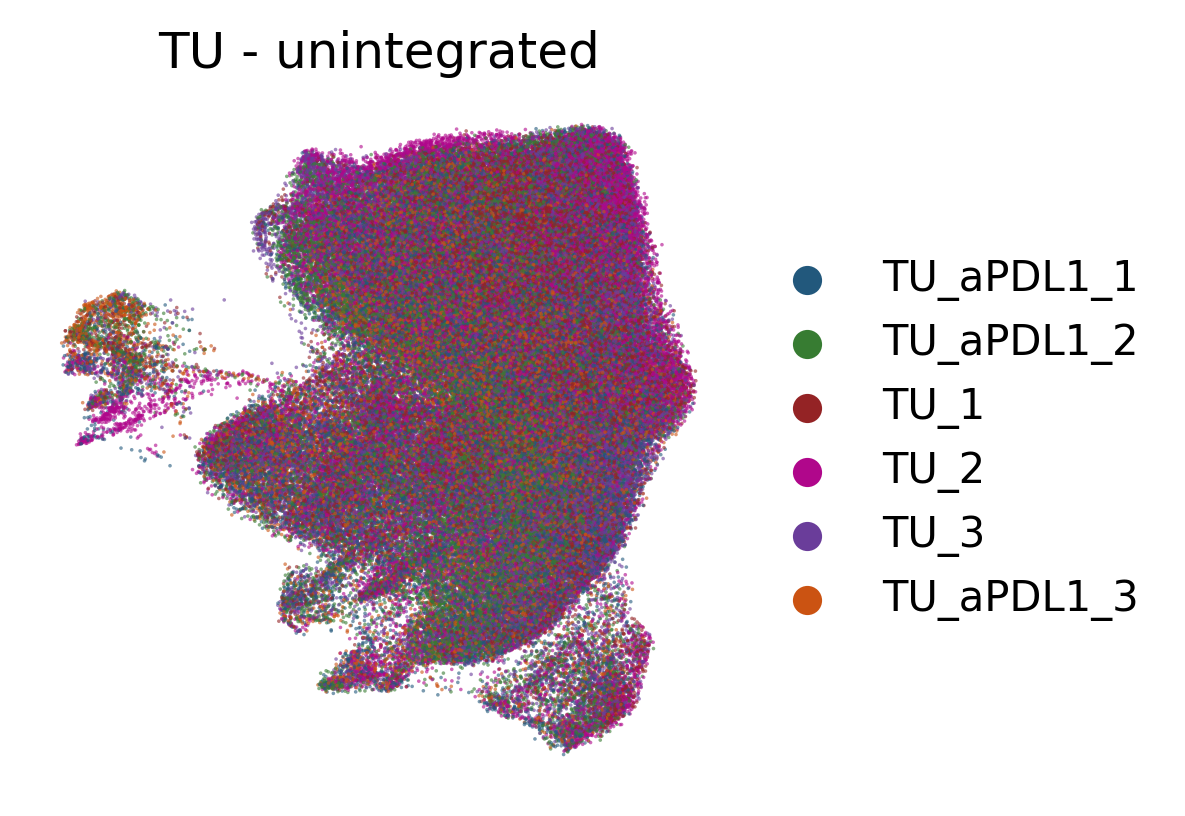

In [ ]:
colors = [
    "#22587C",
    "#377C32",
    "#942325",
    "#B0078B",
    "#6A3D9A",
    "#CB5312",
]
with plt.rc_context({"figure.figsize": (3, 3), "figure.dpi": (300)}):
    sc.pl.umap(
        adata_shuffled,
        color="slide_id",
        size=3,
        alpha=0.6,
        title="TU - unintegrated",
        frameon=False,
        palette=colors
    )

In [55]:
adata_shuffled

AnnData object with n_obs × n_vars = 174367 × 335
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'slide_id'
    uns: 'log1p', 'neighbors', 'pca', 'umap', 'slide_id_colors'
    obsm: 'X_pca', 'X_umap', 'spatial', 'unintegrated', 'drvi', 'harmony', 'scvi'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [ ]:
sc.pp.neighbors(
    adata_shuffled,
    use_rep="harmony",
    key_added="neighbors_harmony"
)
sc.tl.umap(
    adata_shuffled,
    neighbors_key="neighbors_harmony",
    key_added="X_umap_harmony"
)

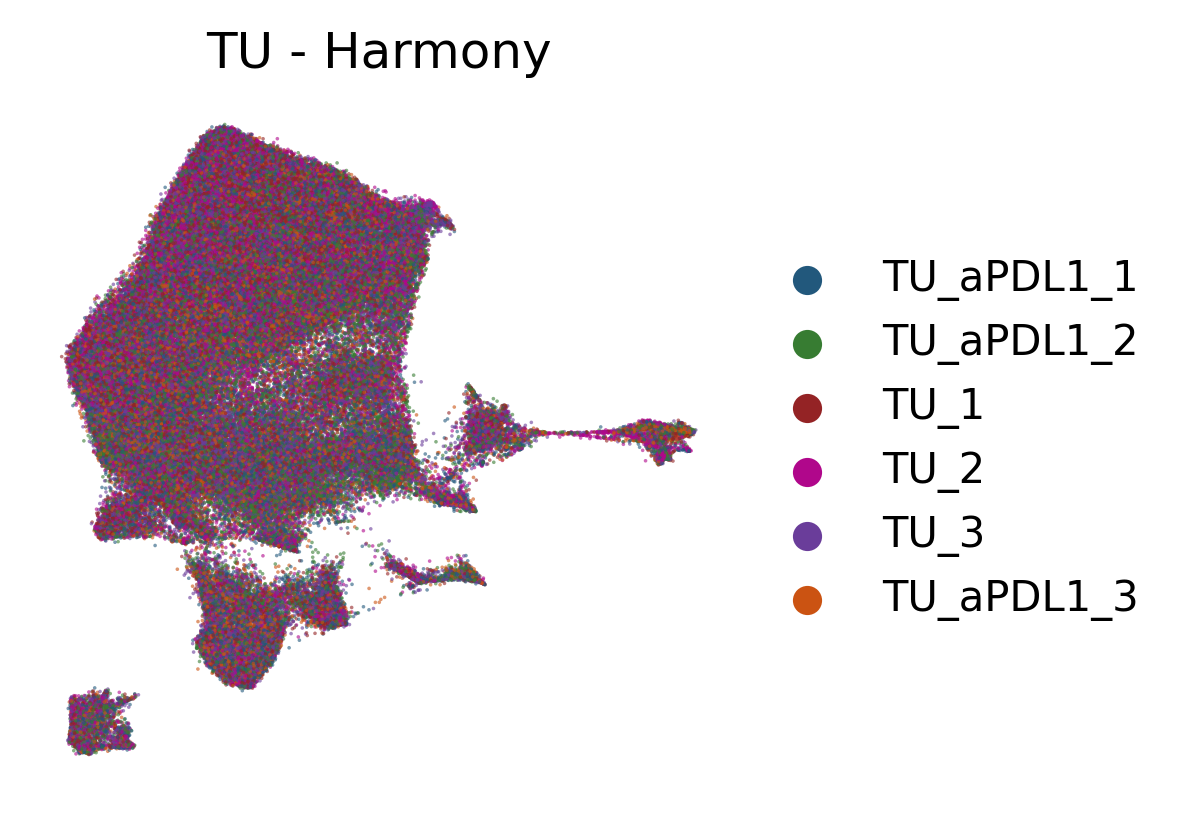

In [ ]:
sc.pp.neighbors(
    adata_shuffled,
    use_rep="harmony",
    key_added="neighbors_harmony"
)
sc.tl.umap(
    adata_shuffled,
    neighbors_key="neighbors_harmony",
    key_added="X_umap_harmony",
    min_dist=0.1
)
with plt.rc_context({"figure.figsize": (3, 3), "figure.dpi": (300)}):
    sc.pl.embedding(
        adata_shuffled,
        color="slide_id",
        size=3,
        alpha=0.6,
        title="TU - Harmony",
        frameon=False,
        palette=colors,
        basis="X_umap_harmony"
    )

In [2]:
import pickle

with open("/home/icb/raphael.kfuri-rubens/git/mempel_xenium/integration_bm_results/bm.pkl", "rb") as fh:
    bm = pickle.load(fh)

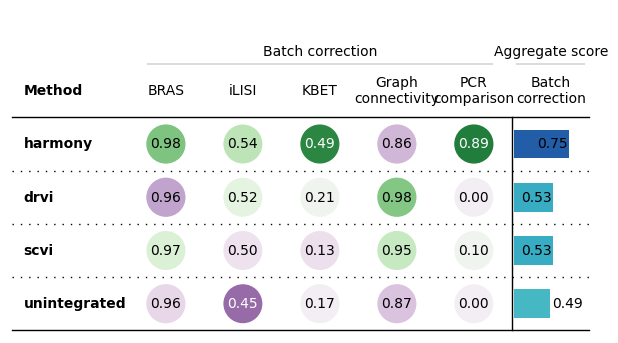

In [ ]:
bm.plot_results_table()

In [61]:
adata_mca = sc.read_h5ad("/home/icb/raphael.kfuri-rubens/git/mempel_xenium/resegmentation_adatas_merged/merged_MCA.h5ad")
adata_mca

AnnData object with n_obs × n_vars = 4039774 × 335
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'slide_id'
    uns: 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [62]:
adata_mca.obs["slide_id"].value_counts(dropna=False)

slide_id
resegment_output-XETG00212__0023280__Region_1__20240917__175222_MCA205_d21_    1000255
resegment_output-XETG00323__0023078__MCA205_d4_aPDL1__20240809__204811          805742
resegment_output-XETG00323__0023214__MCA205_d14__20240809__204811               778776
resegment_output-XETG00323__0023214__MCA205_d21__20240809__204811               606169
resegment_output-XETG00323__0023078__MCA205_d2_aPDL1__20240809__204811          588123
resegment_output-XETG00212__0023182__MCA205_d7__20240809__203238                260709
Name: count, dtype: int64

In [64]:
mapping = {
    "resegment_output-XETG00212__0023280__Region_1__20240917__175222_MCA205_d21_": "Region_1_MCA_205_d21",
    "resegment_output-XETG00323__0023078__MCA205_d4_aPDL1__20240809__204811": "MCA205_aPDL1_d4",
    "resegment_output-XETG00323__0023214__MCA205_d14__20240809__204811": "MCA205_d14",
    "resegment_output-XETG00323__0023214__MCA205_d21__20240809__204811": "MCA205_d21",
    "resegment_output-XETG00323__0023078__MCA205_d2_aPDL1__20240809__204811": "MCA205_aPDL1_d2",
    "resegment_output-XETG00212__0023182__MCA205_d7__20240809__203238": "MCA205_d7"
}
adata_mca.obs["slide_id"] = adata_mca.obs["slide_id"].replace(mapping)
adata_mca.obs["slide_id"].value_counts(dropna=False)

/tmp/ipykernel_1640154/3157069370.py:9: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata_mca.obs["slide_id"] = adata_mca.obs["slide_id"].replace(mapping)


slide_id
Region_1_MCA_205_d21    1000255
MCA205_aPDL1_d4          805742
MCA205_d14               778776
MCA205_d21               606169
MCA205_aPDL1_d2          588123
MCA205_d7                260709
Name: count, dtype: int64

In [65]:
adata_mca.obsm["unintegrated"] = adata_mca.obsm["X_pca"]

In [66]:
emb_dir = "/home/icb/raphael.kfuri-rubens/git/mempel_xenium/resegmentation_integration_embs"
tu_files = [f for f in os.listdir(emb_dir) if "MCA" in f]

for file in tu_files:
    filepath = os.path.join(emb_dir, file)
    with open(filepath, "rb") as f:
        emb = pickle.load(f)
    if "drvi" in file:
        adata_mca.obsm["drvi"] = emb
    if "harmony" in file:
        adata_mca.obsm["harmony"] = emb
    if "scvi" in file:
        adata_mca.obsm["scvi"] = emb

adata_mca

AnnData object with n_obs × n_vars = 4039774 × 335
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'slide_id'
    uns: 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'unintegrated', 'scvi', 'harmony', 'drvi'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [ ]:
obs = adata_mca.obs

groups = obs.groupby("slide_id").groups  

keep_indices = []

for slide, idx in groups.items():
    idx = np.array(list(idx))
    n = len(idx)
    n_sub = max(1, int(n * 0.05))
    chosen = np.random.choice(idx, size=n_sub, replace=False)
    keep_indices.extend(chosen)

adata_mca_sub = adata_mca[keep_indices].copy()

/tmp/ipykernel_1640154/2110759683.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = obs.groupby("slide_id").groups


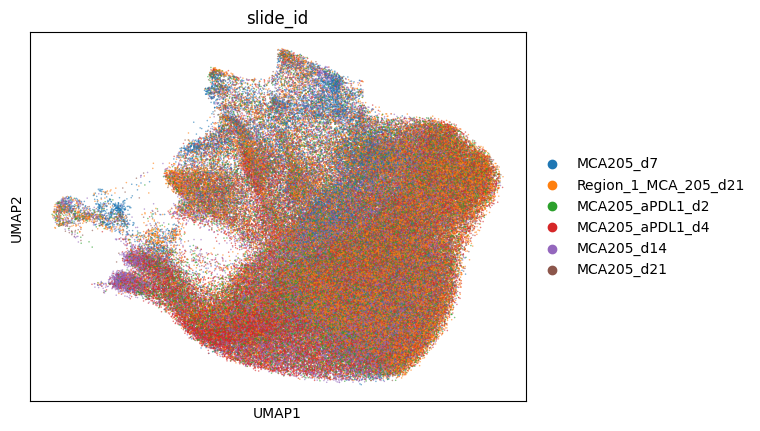

In [68]:
idx = np.random.permutation(adata_mca_sub.n_obs)
adata_shuffled_mca = adata_mca_sub[idx, :].copy()
sc.pl.umap(adata_shuffled_mca, color="slide_id", size=5, alpha=0.6)

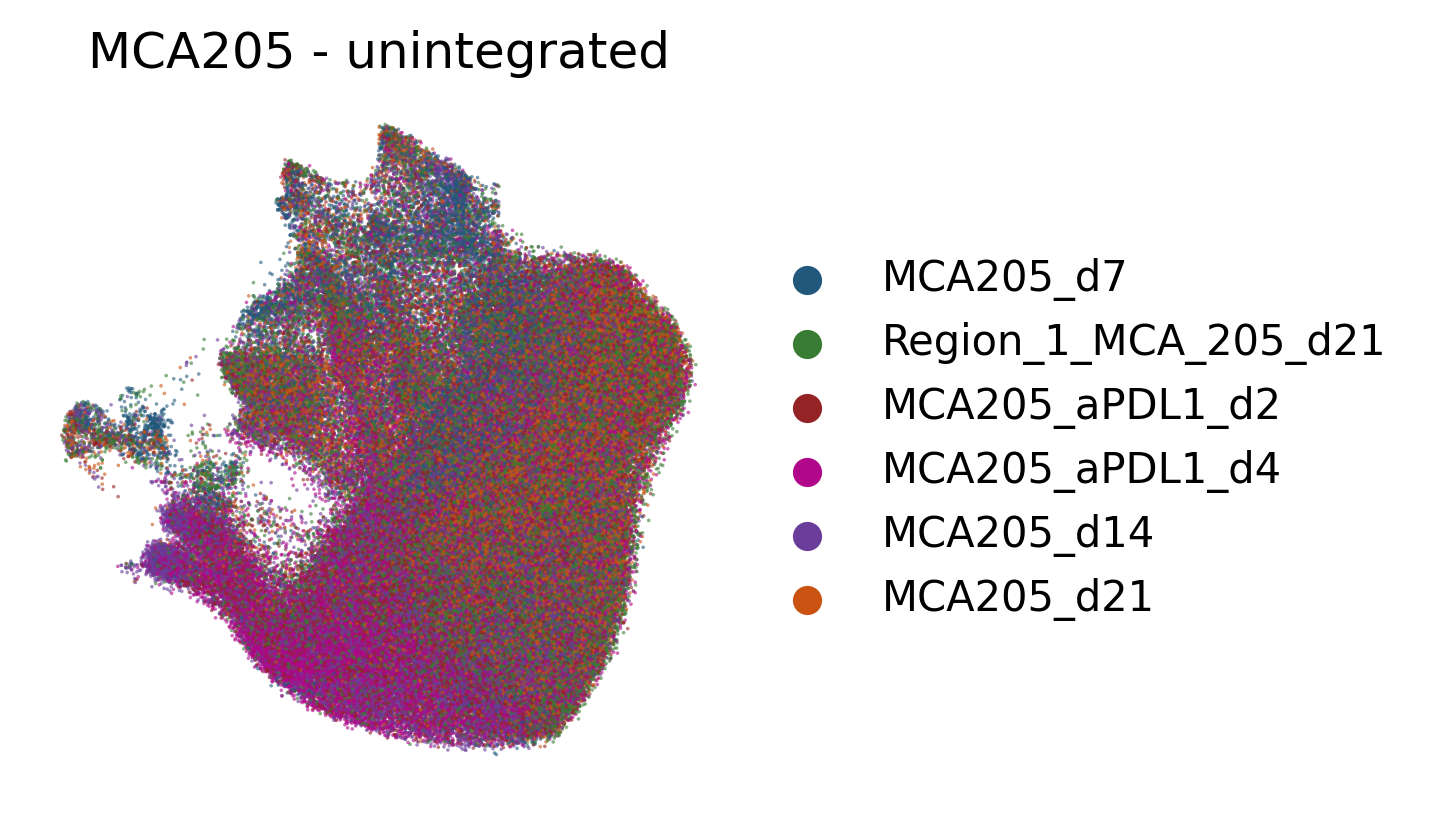

In [ ]:
with plt.rc_context({"figure.figsize": (3, 3), "figure.dpi": (300)}):
    sc.pl.umap(
        adata_shuffled_mca,
        color="slide_id",
        size=3,
        alpha=0.6,
        title="MCA205 - unintegrated",
        frameon=False,
        palette=colors
    )

In [ ]:
sc.pp.neighbors(
    adata_shuffled_mca,
    use_rep="harmony",
    key_added="neighbors_harmony"
)
sc.tl.umap(
    adata_shuffled_mca,
    neighbors_key="neighbors_harmony",
    key_added="X_umap_harmony"
)

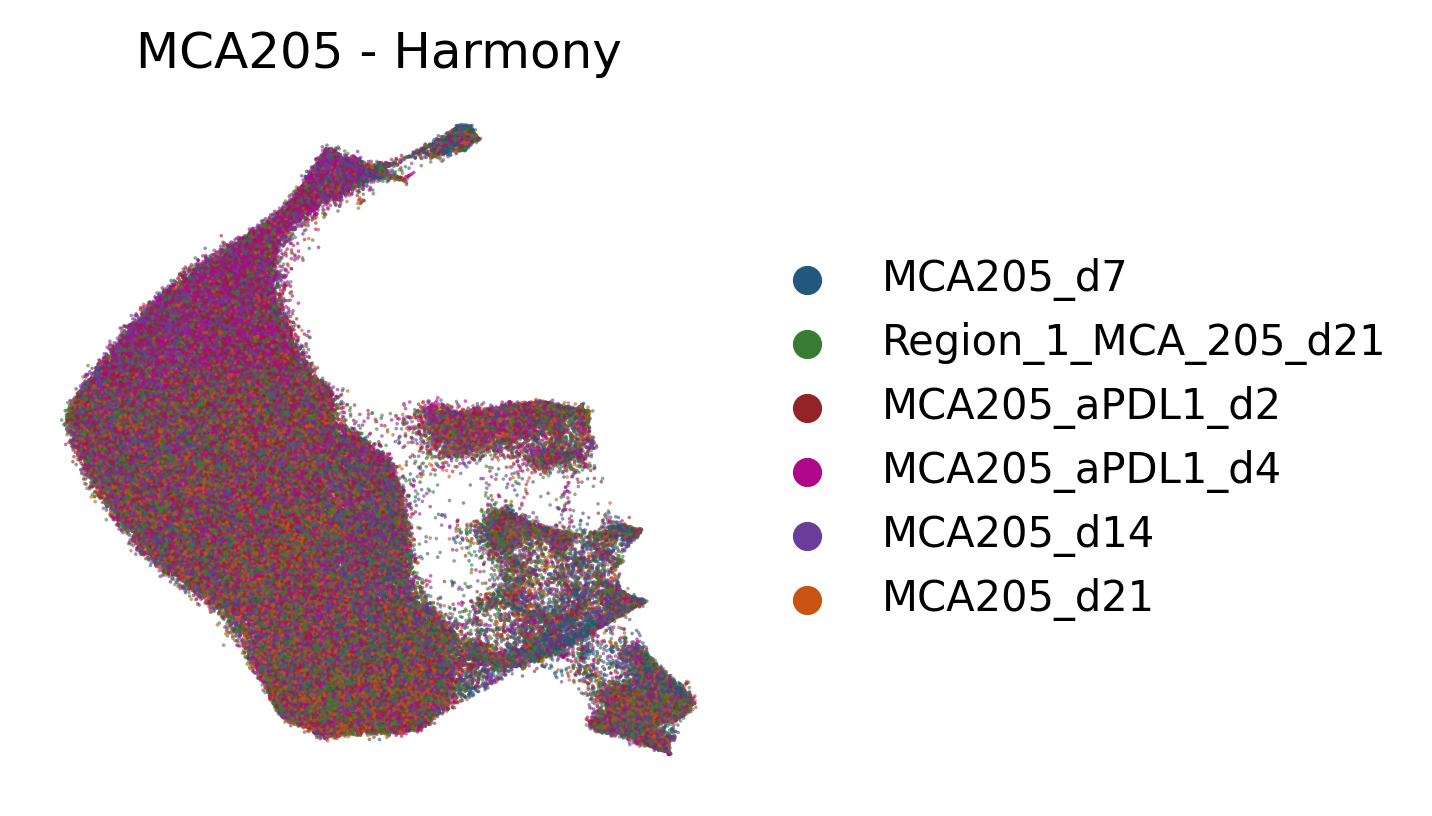

In [ ]:
sc.pp.neighbors(
    adata_shuffled_mca,
    use_rep="harmony",
    key_added="neighbors_harmony"
)
sc.tl.umap(
    adata_shuffled_mca,
    neighbors_key="neighbors_harmony",
    key_added="X_umap_harmony",
    min_dist=0.1
)
with plt.rc_context({"figure.figsize": (3, 3), "figure.dpi": (300)}):
    sc.pl.embedding(
        adata_shuffled_mca,
        color="slide_id",
        size=3,
        alpha=0.6,
        title="MCA205 - Harmony",
        frameon=False,
        palette=colors,
        basis="X_umap_harmony"
    )

In [81]:
del adata_tu.varm["PCs"]
del adata_tu.uns["pca"]
del adata_tu.uns["umap"]
del adata_tu.uns["neighbors"]
del adata_tu.obsm["X_pca"]
del adata_tu.obsm["X_umap"]
del adata_tu.obsp["connectivities"]
del adata_tu.obsp["distances"]

adata_tu

AnnData object with n_obs × n_vars = 3487396 × 335
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'slide_id'
    uns: 'log1p'
    obsm: 'spatial', 'unintegrated', 'drvi', 'harmony', 'scvi'
    layers: 'counts'

In [82]:
del adata_mca.varm["PCs"]
del adata_mca.uns["pca"]
del adata_mca.uns["umap"]
del adata_mca.uns["neighbors"]
del adata_mca.obsm["X_pca"]
del adata_mca.obsm["X_umap"]
del adata_mca.obsp["connectivities"]
del adata_mca.obsp["distances"]

adata_mca

AnnData object with n_obs × n_vars = 4039774 × 335
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'slide_id'
    uns: 'log1p'
    obsm: 'spatial', 'unintegrated', 'scvi', 'harmony', 'drvi'
    layers: 'counts'

In [83]:
adata_tu.write_h5ad("/home/icb/raphael.kfuri-rubens/git/mempel_xenium/resegmentation_final_adatas/tu_pre_final.h5ad")

In [84]:
adata_mca.write_h5ad("/home/icb/raphael.kfuri-rubens/git/mempel_xenium/resegmentation_final_adatas/mca_pre_final.h5ad")

In [1]:
import scanpy as sc

adata = sc.read_h5ad("/home/icb/raphael.kfuri-rubens/git/mempel_xenium/resegmentation_final_adatas/tu_final.h5ad")

In [2]:
adata

AnnData object with n_obs × n_vars = 3487396 × 335
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'slide_id'
    uns: 'X_umap_drvi', 'X_umap_harmony', 'X_umap_scvi', 'X_umap_unintegrated', 'log1p', 'neighbors_drvi', 'neighbors_harmony', 'neighbors_scvi', 'neighbors_unintegrated'
    obsm: 'X_umap_drvi', 'X_umap_harmony', 'X_umap_scvi', 'X_umap_unintegrated', 'drvi', 'harmony', 'scvi', 'spatial', 'unintegrated'
    layers: 'counts'
    obsp: 'neighbors_drvi_connectivities', 'neighbors_drvi_distances', 'neighbors_harmony_connectivities', 'ne

In [3]:
sc.tl.leiden(
    adata,
    resolution=0.1,
    key_added="leiden_0_1",
    neighbors_key="neighbors_harmony"
)

/tmp/ipykernel_608785/3852135827.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


KeyboardInterrupt: 